In [24]:
# Fill in your name using the given format
your_name = "Rangaraj, Pavan Aakash"

In [25]:
# For use in colab
if 'google.colab' in str(get_ipython()):
  !python -m pip install -r student-requirements.txt --quiet

In [26]:
# Uncomment the following line to run in Google Colab
# This will link the notebook to your Google drive to store your models and cache the dataset.
# This will probably ask you to click on a link to get a verification code.

# from google.colab import drive
# import gdown
# drive.mount('/content/drive', force_remount=True)

# Assignment 1
The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. 

American Sign Language(ASL) is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by the movement of hands and faces. 

For this assignment, we will study classifiers on the Sign MNIST dataset. The dataset consists of images of hand signs, each image is of 28 x 28 size and in grayscale format. The dataset format is patterned to match closely with the classic MNIST. Images in the dataset belong to a label from 0–25 representing letters from A-Z(but no cases of 9=J or 25=Z as they involve hand motion).

<img src='https://drive.google.com/uc?id=1TjxZ-AO45PNcCYis_HqDjb8d2__7QJi3'>


In [27]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

import validation

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.2.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [28]:
# Loading Sign MNIST data from OpenML.
# Don't overwrite the X, X_eval and y, y_eval variables anywhere in this notebook. 
# Seriously, don't.

data = openml.datasets.get_dataset(45082)
sign_mnist_X, sign_mnist_y, _, _ = data.get_data(target=data.default_target_attribute)

X = sign_mnist_X.iloc[:27455]
y = sign_mnist_y.iloc[:27455]
X = X/255
y = y.astype('category')

X_eval = sign_mnist_X.iloc[27455:].reset_index(drop = True)
y_eval = sign_mnist_y.iloc[27455:].reset_index(drop = True)
X_eval = X_eval/255
y_eval = y_eval.astype('category')

# These are the letters corresponding to each sign (our 24 classes)
data_classes = {0:"A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 
                6: "G", 7: "H", 8: "I", 10: "K", 11: "L", 12: "M", 
                13: "N", 14: "O", 15: "P", 16: "Q", 17: "R", 18: "S",
                19: "T", 20: "U", 21: "V", 22: "W", 23: "X", 24:"Y"}
letter_to_index = {v: k for k, v in data_classes.items()}

In [6]:
# Plotting helper functions. Don't edit these.
%matplotlib inline
from IPython import display
from tqdm.notebook import tqdm_notebook

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in tqdm_notebook(param_range):
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

# Plots data instances as 28x28 images
def plot_examples(images, labels, row_length=5, title=""):
    """ Renders a set of images
    images -- an array of 28x28 images as 1D vectors
    labels -- the corresponding labels for each image
    row_length -- how many images should be shown per line
    title -- a title for the produced figure
    """
    nr_rows = math.floor(len(images) / row_length)
    if (len(images) % row_length) > 0:
        nr_rows += 1
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(1.5 * row_length, 1.5 * nr_rows))
    for i, n in enumerate(images):
        if len(images) > row_length:
            axes[math.floor(i/row_length)][i%row_length].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            if labels is not None:
              axes[math.floor(i/row_length)][i%row_length].set_xlabel(data_classes[int(labels[i])])
            axes[math.floor(i/row_length)][i%row_length].set_xticks(())
            axes[math.floor(i/row_length)][i%row_length].set_yticks(())

        else:
            axes[i].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            if labels is not None:
              axes[i].set_xlabel(data_classes[int(labels[i])])
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    fig.suptitle(title)       
    plt.show();

# Plots the coefficients of the given model as 28x28 heatmaps. 
def plot_coefficients(coef, name):
    """ Renders a 28x28 heatmap of the model's trained coefficients.
    Keyword arguments:
    coef -- the model coefficients
    name -- a title for the produced figure
    """
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    fig.suptitle(name)
    ax.imshow(coef.reshape(28,28))
    ax.set_xticks(()), ax.set_yticks(())

### Peeking at the data
If we plot the hand signs, we see that there is quite some variation. The same
letter can be represented in an slightly different way using the hand.

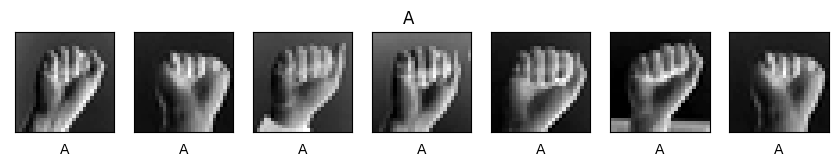

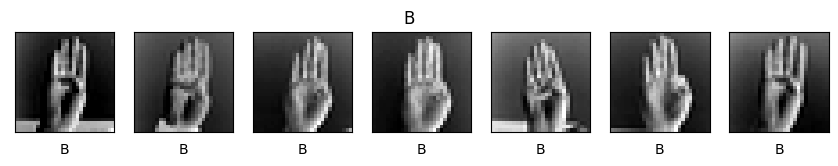

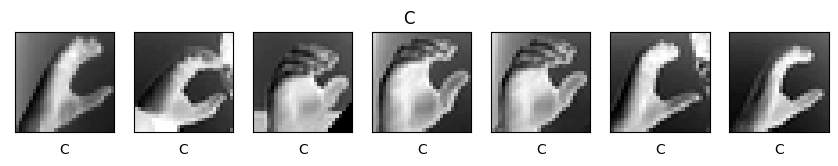

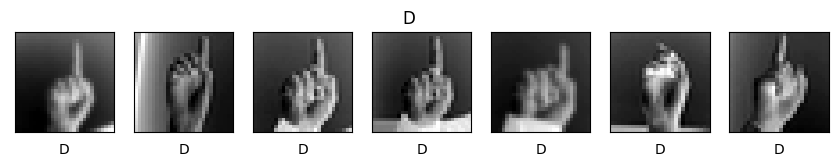

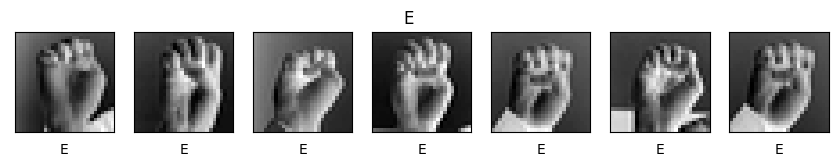

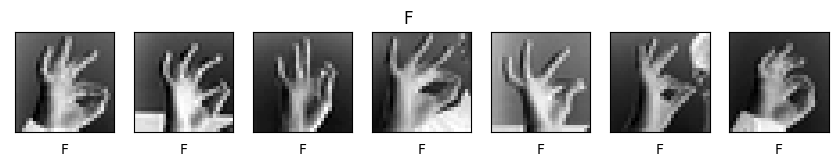

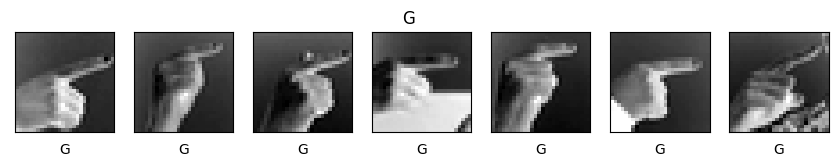

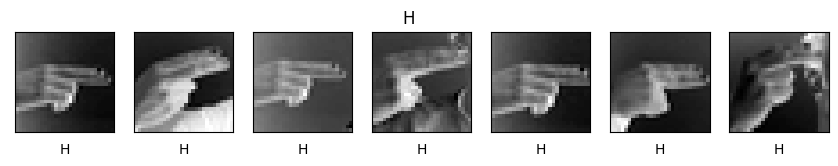

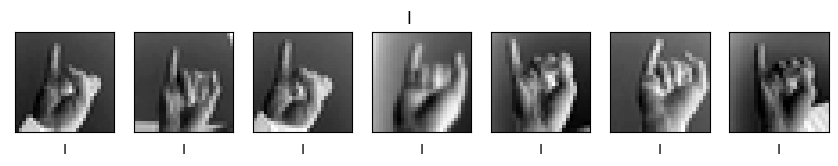

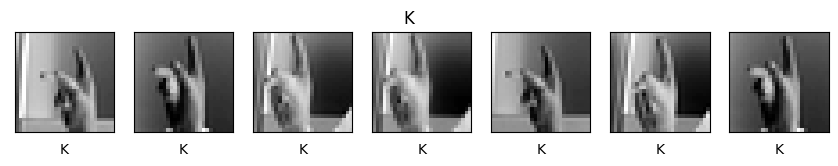

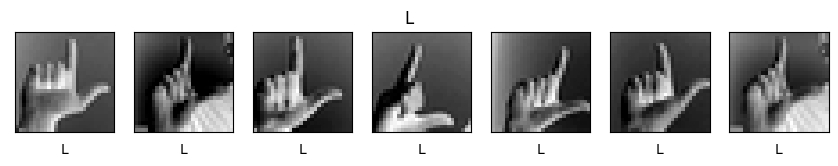

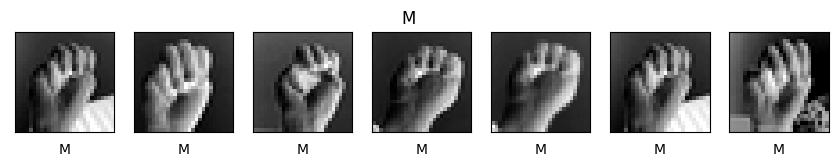

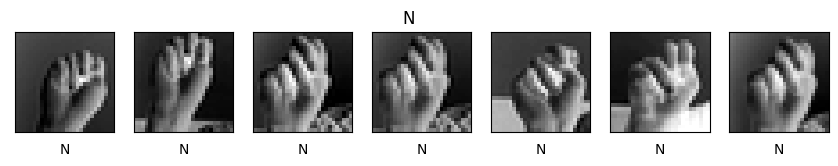

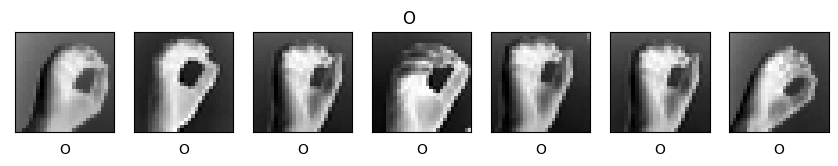

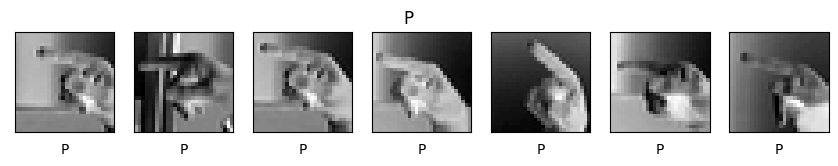

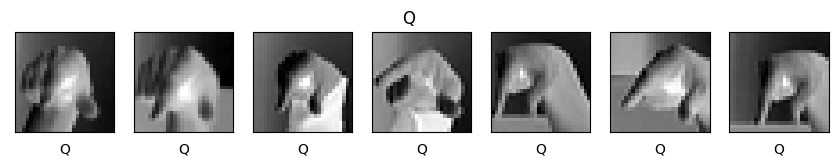

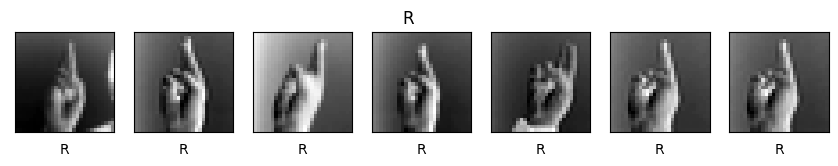

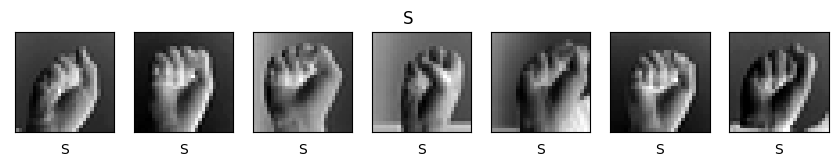

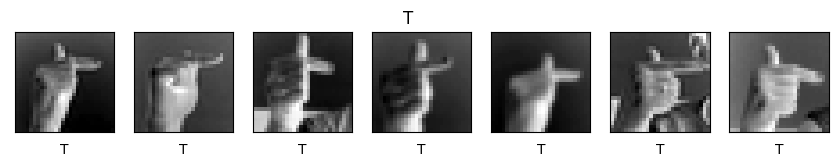

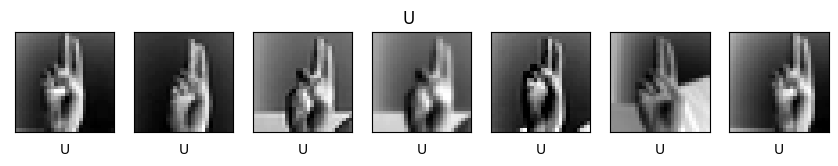

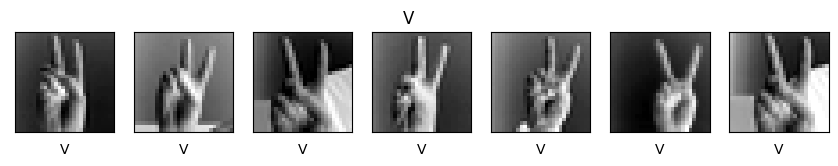

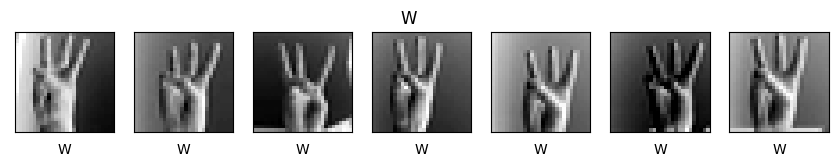

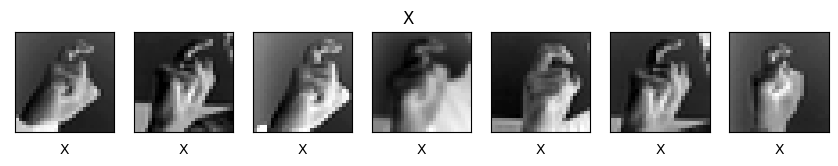

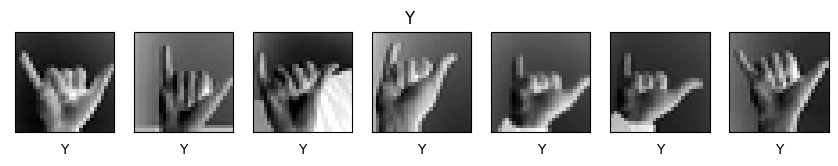

In [9]:
# Gets indices of examples with the given class
def y_class(c):
    return y[y == c].index.values.tolist()[10:17]

for i in [i for i in range(25) if i != 9]:
    plot_examples(X.to_numpy()[y_class(i)], y.to_numpy()[y_class(i)], 
                  row_length=7, title=data_classes[i])

### Question 1.1: Cross-validate (1 point)
Implement a method `evaluate_LR` that evaluates a Logistic Regression model for a given regularization constant (C) and returns the train and test score of a 10-fold stratified cross-validation using the accuracy metric. Note: we know that Logistic Regression is not the best technique for image data :). We'll use other techniques in future assignments.

**Important:** Only use the variables passed as parameters (in this case, `X`, `y`, and `C`). Do not add additional parameters to the function, and do not use global variables in the function implementation (except for imported modules and functions, which you are free to use). These guidelines also apply to any future questions in this and future assignment(s).

In [21]:
# Implement
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def evaluate_LR(X, y, C):
    """ Evaluate an LR with 10-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    C -- the value for the regularization hyperparameter
    
    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    model= LogisticRegression(C=C,penalty="l2",max_iter=1000) #LogisticRegressionCV by default uses the stratified 10-fold cross-validation
    Scaler=StandardScaler().fit(X)
    X_scaled=Scaler.transform(X)
    scores = cross_validate(model, X_scaled, y, cv=2, return_train_score=True)
    return {"train": scores['train_score'].mean(), "test": scores['test_score'].mean()}

In [24]:
evaluate_LR(X, y, 1)

{'train': 1.0, 'test': 0.980621462478064}

*note:* Throughout the notebook, you will find cells like the one below that call functions on the `validation` module. You should run these cells to perform a _very_ basic test on your provided answer. If validation fails, that means there is a technical error with the provided answer (e.g., the function signature was changed). Passing validation does *not* necessarily mean your answer is correct. It is *not* a replacement for performing your own sanity checks.

In [15]:
validation.is_legal_function(evaluate_LR)

### Question 1.2: Tune (1 point)

Implement a method `plot_curve` that plots the results of `evaluate_LR` on a 25% stratified subsample of the Sign MNIST dataset for C values ranging from 1e-4 (10<sup>-4</sup>) to 1e5 (10<sup>5</sup>) (on a log base 10 scale, at least 10 values). Use `random_state=0`. You can use the plotting function `plot_live` defined above (carefully read what it does), and add any helper functions you like. Note:  To be clear, you need to pass only 25% of the data to `evaluate_LR`. Using a 25% subsample won't give you optimal performance, but this is meant to make the function run faster which makes it easier to test your implementation for the purpose of the assignment.

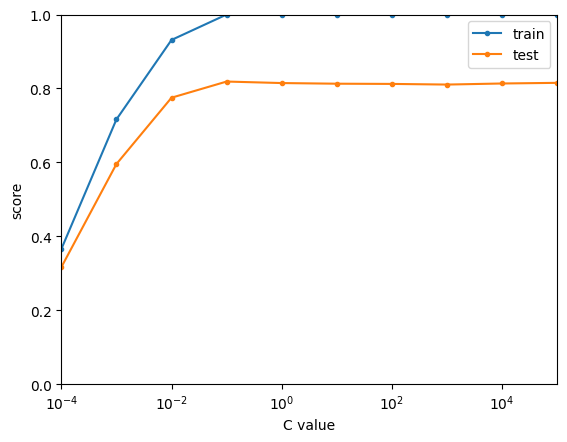

In [25]:
# Implement. Do not change the name or signature of this function.
def plot_curve(X,y):
    """ Plots the train and test accuracy of logistic regression on a 25% 
    subsample of the given data for different amounts of regularization.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: a plot as described above, with C on the x-axis and accuracy on 
    the y-axis. 
    """
    X_train,_,y_train,_ = train_test_split(X, y, test_size=0.75, random_state=0)
    C_range= np.logspace(-4,5,10)
    Scores_train=[]
    Scores_test=[]
    
    plot_live(X_train,y_train,evaluate_LR,"C value",C_range)
plot_curve(X,y)

In [ ]:
validation.is_legal_function(plot_curve)

### Question 1.3: Interpretation (0.5 point)
Interpret the graph. At C=1e-3, is the model underfitting, overfitting, or neither? What about the model trained with C=1e4? Below are a number of possible interpretations. Enter the correct letter in value `q_1.3` in the code.
  
- 'A': Overfitting at C=1e-3, underfitting at C=1e4.
- 'B': Underfitting at C=1e-3, overfitting at C=1e4.  
- 'C': Neither underfitting nor overfitting at C=1e-3, overfitting at C=1e4.
- 'D': Neither underfitting nor overfitting at C=1e-3, underfitting at C=1e4.
- 'E': Overfitting at C=1e-3, neither significantly underfitting nor overfitting at C=1e4.
- 'F': Underfitting at C=1e-3, neither significantly underfitting nor overfitting at C=1e4.
- 'G': Neither underfitting nor overfitting at both values for C.
- 'H': No answer

In [ ]:
# Fill in the correct answer. Don't change the name of the variable
q_1_3 = 'H'

In [ ]:
validation.is_legal_answer(q_1_3, n_options=8)

### Question 2.1: Characters subsets (1 point)


Create a function to retrieve a subset of all images containing hand sign for a specific list of characters provided as argument to the function. Implement `get_subset()` to select a subset of hand sign images representing only the characters from a list. The function should retrieve all images for the given character(s) and no images of other classes.



In [33]:
# Implement. Do not change the name or signature of this function.
def get_subset(X, y, characters_list):
    """ Select the subset from X that contains only the images representing
        the classes from characters_list
    X -- the data to sample from
    y -- all the labels
    characters_list -- the required list of characters (classes)
    
    Returns: A dataframe containing a subset of X with classes only from characters_list
    """

    length=25
    search_index=[letter_to_index[letter] for letter in characters_list]
    index_list=[]

    for i in range(len(y)):
        if y[i] in search_index :
            index_list.append(i)
            
    subset=X.iloc[index_list]
    subset=subset.reset_index(drop=True)
    print(type(subset))
    return subset


# You can use the code below to visualize the results.
#ab_subset = get_subset(X, y, ['C', 'B'])
#plt.imshow(ab_subset.sample(1).to_numpy().reshape(28, 28), cmap = "gray")

In [34]:
validation.is_legal_function(get_subset, X, y, characters_list=["A", "B"])

<class 'pandas.core.frame.DataFrame'>


### Question 2.2: Model inspection (1 points)
Implement a function `plot_sign_coefficients` that plots a heatmap of the coefficients of three models (after training), one trained with C=1e-4, one with C=0.01, and one with C=1. You can use the `plot_coefficients` helper function (see above). 

Only plot the coefficients of the model that separates the signs for characters `A` and `B` from the other signs. You can assume that a one-vs-rest-like approach is used for multi-class problems, hence the n-th set of coefficients belong to the model that separates the n-th class. Select one element of the subset returned by `get_subset()` for both [`A`] and [`B`] characters and plot them together with the coeficients. You should get eight plots (2 sets of four plots: one character plot and three coeficients plots) in total.

First split the data in a default stratified train-test split. Train the models on the training data and score the accuracy on the test data. Add the C-value and test accuracy to the title of the plots. 

Note: You may get convergence warnings. If so, just increase the number of optimization iterations (`max_iter`). Especially models with high C values can take longer to converge (can you guess why?). You can also choose to ignore these warnings since they won't affect the results much. Don't set it too high since that will take to long to run.  

Note 2: Scikit-learn actually uses [a more sophisticated approach](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py) here than simple one-vs-all. It uses the fact that Logistic Regression predicts probabilities, and hence the probabilities of each class are taken into account (in a softmax function). It will still produce one model per class.

In [ ]:
# Implement. Do not change the name or signature of this function.
def plot_sign_coefficients(X, y, character):
    """ Plots 28x28 heatmaps showing the coefficients of three Logistic 
    Regression models, each with different amounts of regularization values.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: 4 plots, as described above.
    """
    pass

plot_sign_coefficients(X, y, None)

In [ ]:
validation.is_legal_function(plot_sign_coefficients)

### Question 2.3: Interpretation (1 points)
Interpret the coefficients plots. Is there any difference between the coeficients for 'A' and the ones for 'B'? For each plotted C, is the model underfitting or overfitting? Below are a number of possible interpretations. Enter the correct letter(s) in value `q_2.3` in the code. They may be separated by spaces, commas, or both (e.g.,: `'ABC'` , `'A,B,C'`, or `'A, B, C`').

  
- 'A': The coefficients for character `A` and `B` are looking very similar.
- 'B': The coefficients for character `A` and `B` are quite different. 
- 'C': For C=1e-4, the model is overfitted for both characters.
- 'D': For C=1e-4, the model is underfitted for both characters.
- 'E': For C=1, the model is overfitted for both characters.
- 'F': For C=1, the model is underfitted for both characters.
- 'G': The middle coefficient plot has a good balance in capturing the different ways to show the characters `A` and `B`.
- 'H': The first coefficient plot has a good balance in capturing the different ways to show the characters `A` and `B`.
- 'I': The last coefficient plot has a good balance in capturing the different ways to show the characters `A` and `B`.
- 'J': No answer

In [ ]:
# Fill in the correct answer(s). Don't change the name of the variable
q_2_3 = 'J'

In [ ]:
validation.is_legal_answer(q_2_3, n_options=10)

### Question 3.1: Confusion matrix heatmap (0.5 point)

Plot the confusion matrix for all the 24 characters classes as a heatmap. First split the data again in a default stratified train-test split. Train a Logistic Regression model on the training data and produce the predictions on the test set. Compute the confusion matrix based on the predictions on the testing data. Plot the matrix as a heatmap without any annotation. Given the large number of classes, there is no need to display in the plot the number (or percentages) corresponding to each cell of the matrix.

Implement `plot_confusion_matrix()` function to compute the confusion matrix (using [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)) and to display the matrix as a heatmap.

In [ ]:
# Implement the confusion matrix plot here
def plot_confusion_matrix(X, y):
  pass

plot_confusion_matrix(X, y)

In [ ]:
validation.is_legal_function(plot_confusion_matrix)

### Question 3.2: Mistake analysis (1 point)

Let's now focus on the sign for character 'K' and the behavior of the model with C=1e-2.

First split the data again in a default stratified train-test split. Train the models on the training data and produce the predictions on the test data.

Next, take the test examples which actually represent 'K'. From these, identify the ones which are predicted correctly and which ones are not. Calculate the confusion matrix and based on that print the Top-5 characters that are wrongly classified as 'K' along with their count.

Finally, plot these examples using the `plot_examples` function, together with the predicted class (character). Create two plots (e.g. by calling `plot_examples` twice): one with 20 examples of signs for 'K' character which are predicted correctly, and a second with 20 examples of signs for 'K' character which are predicted incorrectly by this model. Indicate in the figure `title` which 'K' characters are correct and which ones are misclassified.

In [ ]:
# Implement. Do not change the name or signature of this function.
def plot_mistakes(X,y,character):
    """ Plots two sets of images. The first set shows 20 examples of characters
    predicted correctly by a Logistic Regression classifier with C=1e-2. The 
    second set shows 20 examples of misclassifications. 
    X -- the data for training and testing
    y -- the correct labels
    Returns: 2 sets of plots, as described above.
    """
    pass

plot_mistakes(X,y,'K')

In [ ]:
validation.is_legal_function(plot_mistakes)

## Question 3.2: Interpretation (0.5 point)
Interpret the missclasified signs of the Logistic Regression model with C=1e-2.Enter the correct letter in value `q_3.2` in the code.

  
- 'A': The sign for `K` is misclassified often with `V`
- 'B': The sign for `K` is misclassified often with `C`
- 'C': The sign for `K` is misclassified often with `A`
- 'D': The sign for `K` is misclassified often with `Q`
- 'E': No answer

In [ ]:
# Fill in the correct answer. Don't change the name of the variable
q_3_2 = 'E'

In [ ]:
validation.is_legal_answer(q_3_2, n_options=5)

### Question 4.1 : HOG features (1 point)
Until now, we only used the pixel representation. There are may other ways of feature representation that work much better. One of these is the histogram of oriented gradients (HOG), which counts the occurrences of gradient orientations in localized portions of an image. You can read more about HOG feature descriptors [here](https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f).

Using the **scikit-image** implementation, compute the hog features of an image containing a sign for *K* character. You can have a look at this [tutorial](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html). Implement a method `plot_hog_feature` showing an original image and its hog representation side by side. Play with different cell sizes to get a visually better representation. Finally, implement a method `plot_hog_features` that plots multiple cell sizes at once.

This question is deliberative more free-from. You can make your own decisions as long as you adhere to the general method signatures and produce the right output.

In [ ]:
# Implement. Do not change the name or signature of this function.
def plot_hog_feature(original_image, hog_image, cell_size = 2):
  pass

# Implement. Do not change the name or signature of this function.
def plot_hog_features(X, y, character):
  pass

plot_hog_features(X,y, 'K')

In [ ]:
validation.is_legal_function(plot_hog_features)
validation.is_legal_function(plot_hog_feature)

### Question 4.2 : Edge features (0.5 point)

Edge Detection is when we use matrix math to calculate areas of different intensities of an image. Areas where there are extreme differences in the intensities of the pixel usually indicate an edge of an object. After finding all of the large differences in intensities in a picture, we have discovered all of the edges in the picture. Sobel Edge detection is a widely used algorithm of edge detection in image processing. Along with Canny and Prewitt, Sobel is one of the most popular edge detection algorithms used in today's technology. You can read more [here](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html).

Using the *scikit-image*([scikit-image.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel)), compute the Sobel features of three images containing signs for these characters: *C*, *K*, *W*. Implement `plot_edges` function to compute the new features for the three images and plot the resulted edges togheter with the original images.



In [ ]:
# Implement. Do not change the name or signature of this function.
# Function should return three pairs of plots (original_image, edge_image)
# For showing the images, use cmap="gray"
def plot_edges(X, y):
  pass

plot_edges(X, y)

In [ ]:
validation.is_legal_function(plot_edges)

## Question 4.3 : Model evaluation (1 point)

Now it's time to use the evaluation set `(X_eval, y_eval)`.

**NOTE: This is the only exercise in which you should use the evaluation set.**

Compute both the *HOG features* (inside a function named `compute_hog_feats`) and *Edge features* (inside a function named `compute_edges`) for the whole `(X,y)` dataset.
Train a Logistic Regression model for both sets of features and evaluate the performance of the two models on `(X_eval, y_eval)`.
Compare the accuracy on the evaluation set with the performance of the model that uses raw pixels as features. Conclude which model is better.

Implement `final_evaluator` function that takes the features computed for `X` and `X_eval`, train the best Logistic Regression model and reports the accuracy on the evaluation set. 

In [ ]:
# Implement here the evaluator
def final_evaluator(X_features, y, X_eval_features, y_eval):
  pass

# Implement
def compute_hog_feats(X, cell_size):
  pass

# Compute HOG features for the whole X and X_eval by calling compute_hog_feats
X_hog = None
X_eval_hog = None


# Implement
def compute_edges(X):
  pass

# Compute edge features for the whole X and X_eval by calling compute_edges
X_edges = None
X_eval_edges = None


final_evaluator(X_hog, y, X_eval_hog, y_eval) # should print accuracy for HOG features
final_evaluator(X_edges, y, X_eval_edges, y_eval) # should print accuracy for Sobel features
final_evaluator(X, y, X_eval, y_eval) # should print accuracy for pixel features

In [ ]:
validation.is_legal_function(final_evaluator)
validation.is_legal_function(compute_edges)
validation.is_legal_function(compute_hog_feats)

Which model performs better on the evaluation set? Interpret the performance on the evaluation set of the three model: the raw pixels, the edge and the hog features. Enter the correct letter(s) in value `q_4.3` in the code.

  
- 'A': The evaluation data might not be selective from the same data distribution
- 'B': The performance on the evaluation set is comparable to the best cross validation result from Q1.2
- 'C': The raw pixels model performs the best on the evaluation data
- 'D': The hog features model performs the best on the evaluation data
- 'E': The edge features model performs the best on the evaluation data
- 'F': No answer

In [ ]:
# Fill in the correct answer(s). Don't change the name of the variable
q_4_3 = 'F'

In [ ]:
validation.is_legal_answer(q_4_3, n_options=6)